# Data Annotation

- definitions & guidelines
- Tool Augmentation, Syntactic Prompting
- Negative sampling
- Dynamic few-shot choice
- Prompts from errors

## Querying

In [1]:
from openai import OpenAI

client = OpenAI()

In [2]:
import json

def run_query(system_prompt, user_prompt, response_type="json_object"):
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        response_format={"type": response_type}
    )
    result = completion.choices[0].message.content
    
    if response_type == "json_object":
        result = json.loads(result)    
    
    return result

In [3]:
def get_embedding(text):
    text = text.replace("\n", " ")
    
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )

    embedding = response.data[0].embedding
    
    return embedding

## Definitions & Guidelines

In [4]:
import json

with open("../data/definitions.json") as f:
    definitions = json.load(f)
    
del definitions['mode of transport']
definitions

{'human-powered': 'Human powered transport, a form of sustainable transportation, is the transport of people and/or goods using human muscle-power, in the form of walking, running and swimming. Modern technology has allowed machines to enhance human power. Human-powered transport remains popular for reasons of cost-saving, leisure, physical exercise, and environmentalism; it is sometimes the only type available, especially in underdeveloped or inaccessible regions.Although humans are able to walk without infrastructure, the transport can be enhanced through the use of roads, especially when using the human power with vehicles, such as bicycles and inline skates. Human-powered vehicles have also been developed for difficult environments, such as snow and water, by watercraft rowing and skiing; even the air can be entered with human-powered aircraft.',
 'animal-powered': 'Animal-powered transport is the use of working animals for the transport of people and/or goods. Humans may use some 

In [5]:
system_prompt = "You are a helpful NER data annotator designed to output JSON."
dg_user_prompt_template = """
Named Entity: "{entity}". Definition: {definition}. Examples: {examples}.

Instructions: 
1. Provide a concise definition for the named entity "{entity}" in the context of NER.
2. Provide guidelines by specifying what entities should not be labelled as "{entity}" and include potential pitfalls to avoid. Go beyond generic terms and delve into nuanced scenarios. Be explicit about potential ambiguities and provide guidance on distinguishing "{entity}" from similar entities.

Output in JSON format: {{"Definition": "", "Guidelines": ""}}.
"""

In [11]:
entity_vocab_user_prompt = f"""
Here is an entity type set: [{str(list(definitions.keys()))}].
""" + \
'\n'.join([f"The definition of {entity} is {definition};" for entity, definition in definitions.items()]) + \
"""
Please imagine a list of 5 diverse means of transport for each entity type in the set. Think step-by-step. Make sure to follow the definition of each entity. Include only the most relevant means of transport.
Only use names of means of transport, do not include associations.
Only associate one mean of transport with one entity type. If it is ambiguos, do not include it.
Output in JSON format: {"Entity Type 1": ["word1", ...], "Entity Type 2": ["word1", ...], ...}.
"""

entity_vocab = run_query(system_prompt, entity_vocab_user_prompt)
entity_vocab

{'human-powered': ['bicycle',
  'inline skates',
  'rowing boat',
  'kayak',
  'pedal-powered aircraft'],
 'animal-powered': ['horse-drawn carriage',
  'ox-cart',
  'camel caravan',
  'elephant ride',
  'donkey pack'],
 'railways': ['steam locomotive',
  'electric train',
  'diesel train',
  'high-speed train',
  'tram'],
 'roadways': ['automobile', 'motorcycle', 'bus', 'truck', 'motor scooter'],
 'water_transport': ['cargo ship',
  'ferry',
  'sailboat',
  'submarine',
  'hovercraft'],
 'air_transport': ['airplane',
  'helicopter',
  'jet airliner',
  'cargo plane',
  'glider']}

In [12]:
example_generation_user_prompt = f"""
Here is an entity type set: [{str(list(entity_vocab.keys()))}].
Construct a sentence that contains entities from the following words:
""" + \
'\n'.join([f"{entity}: {', '.join(words)};" for entity, words in entity_vocab.items()]) + \
"""
Output the sentence along with the utilized entities. Please imagine 5 different sentences for every entity type. Think step-by-step.
Output in JSON format: {"Entity Type 1": [{"text": "", "entities": {"Entity Type 1": ["value", ...]}}, ...], ...}.
"""

entity_examples = run_query(system_prompt, example_generation_user_prompt)
entity_examples

{'human-powered': [{'text': 'The city park is perfect for riding a bicycle or enjoying a relaxing time with inline skates.',
   'entities': {'human-powered': ['bicycle', 'inline skates']}},
  {'text': 'On weekends, I love taking my kayak to the lake and exploring the serene waters.',
   'entities': {'human-powered': ['kayak']}},
  {'text': 'The rowing boat races on the river draw huge crowds each summer.',
   'entities': {'human-powered': ['rowing boat']}},
  {'text': 'He dreams of piloting a pedal-powered aircraft in the annual airshow.',
   'entities': {'human-powered': ['pedal-powered aircraft']}},
  {'text': 'Inline skates are a great way to improve balance and coordination while having fun.',
   'entities': {'human-powered': ['inline skates']}}],
 'animal-powered': [{'text': 'The traditional village festival features a parade with a majestic elephant ride.',
   'entities': {'animal-powered': ['elephant ride']}},
  {'text': 'In the desert, a camel caravan is essential for transport

In [13]:
entity_metadata = dict()

for entity, examples in entity_examples.items():
    definition = definitions[entity]
    
    items = entity_vocab[entity]
    
    dg_user_prompt = dg_user_prompt_template.format(entity=entity, definition=definition, examples=str(examples))
    result = run_query(system_prompt, dg_user_prompt)
    
    entity_metadata[entity] = {'examples': examples,
                               'items': items,
                               'definition': result['Definition'],
                               'guidelines': result['Guidelines']}

In [14]:
entity_metadata['human-powered']

{'examples': [{'text': 'The city park is perfect for riding a bicycle or enjoying a relaxing time with inline skates.',
   'entities': {'human-powered': ['bicycle', 'inline skates']}},
  {'text': 'On weekends, I love taking my kayak to the lake and exploring the serene waters.',
   'entities': {'human-powered': ['kayak']}},
  {'text': 'The rowing boat races on the river draw huge crowds each summer.',
   'entities': {'human-powered': ['rowing boat']}},
  {'text': 'He dreams of piloting a pedal-powered aircraft in the annual airshow.',
   'entities': {'human-powered': ['pedal-powered aircraft']}},
  {'text': 'Inline skates are a great way to improve balance and coordination while having fun.',
   'entities': {'human-powered': ['inline skates']}}],
 'items': ['bicycle',
  'inline skates',
  'rowing boat',
  'kayak',
  'pedal-powered aircraft'],
 'definition': "In the context of NER, 'human-powered' refers to any form of transportation that relies primarily on human physical effort for mo

In [15]:
with open("../data/entity_metadata.json", "w") as f:
    json.dump(entity_metadata, f, indent=4)

## Prompt optimizations

In [70]:
import json

with open("../data/definitions.json") as f:
    definitions = json.load(f)
    
del definitions['mode of transport']
definitions

{'human-powered': 'Human powered transport, a form of sustainable transportation, is the transport of people and/or goods using human muscle-power, in the form of walking, running and swimming. Modern technology has allowed machines to enhance human power. Human-powered transport remains popular for reasons of cost-saving, leisure, physical exercise, and environmentalism; it is sometimes the only type available, especially in underdeveloped or inaccessible regions.Although humans are able to walk without infrastructure, the transport can be enhanced through the use of roads, especially when using the human power with vehicles, such as bicycles and inline skates. Human-powered vehicles have also been developed for difficult environments, such as snow and water, by watercraft rowing and skiing; even the air can be entered with human-powered aircraft.',
 'animal-powered': 'Animal-powered transport is the use of working animals for the transport of people and/or goods. Humans may use some 

In [66]:
import stanza

stanza.download('en')
nlp = stanza.Pipeline('en', processors='tokenize,pos')

2025-01-23 19:52:54 INFO: Downloaded file to /Users/artempris/stanza_resources/resources.json
2025-01-23 19:52:54 INFO: Downloading default packages for language: en (English) ...


2025-01-23 19:54:18 INFO: Downloaded file to /Users/artempris/stanza_resources/en/default.zip
2025-01-23 19:54:20 INFO: Finished downloading models and saved to /Users/artempris/stanza_resources
2025-01-23 19:54:20 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-01-23 19:54:20 INFO: Downloaded file to /Users/artempris/stanza_resources/resources.json
2025-01-23 19:54:20 WARNING: Language en package default expects mwt, which has been added
2025-01-23 19:54:21 INFO: Loading these models for language: en (English):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| mwt       | combined        |
| pos       | combined_charlm |

2025-01-23 19:54:21 INFO: Using device: cpu
2025-01-23 19:54:21 INFO: Loading: tokenize
2025-01-23 19:54:21 INFO: Loading: mwt
2025-01-23 19:54:21 INFO: Loading: pos
2025-01-23 19:54:22 INFO: Done loading processors!


word: As	POS: SCONJ
word: we	POS: PRON
word: planned	POS: VERB
word: to	POS: PART
word: jet	POS: VERB
word: set	POS: NOUN
word: ,	POS: PUNCT
word: the	POS: DET
word: thought	POS: NOUN
word: of	POS: SCONJ
word: following	POS: VERB
word: the	POS: DET
word: flight	POS: NOUN
word: path	POS: NOUN
word: excited	POS: VERB
word: us	POS: PRON
word: .	POS: PUNCT


In [68]:
def get_tool_augmentation(sentence, engine=nlp):
    doc = engine(sentence)
    pos_tags = [f"{word.text}/{word.pos}" for sent in doc.sentences for word in sent.words]
    pos_text = ' '.join(pos_tags)
    
    return pos_text

In [69]:
text = "As we planned to jet set, the thought of following the flight path excited us."
pos_text = get_tool_augmentation(text)

pos_text

'As/SCONJ we/PRON planned/VERB to/PART jet/VERB set/NOUN ,/PUNCT the/DET thought/NOUN of/SCONJ following/VERB the/DET flight/NOUN path/NOUN excited/VERB us/PRON ./PUNCT'

In [72]:
ta_sp_user_prompt_template = """
Given entity label set: {entity_set}.
Given the text and the corresponding Part-of-Speech tags, please recognize the named entities in the given text. Let's infer named entities step by step from the text based on the given Part-of-Speech tags.
Text: {input_text}
Part-of-Speech tags: {pos_text}
Question: What are the named entities labeled as "{entity}" in the text?
Answer:
"""

ta_sp_user_prompt = ta_sp_user_prompt_template.format(entity_set=str(list(definitions.keys())), 
                                  input_text=text, pos_text=get_tool_augmentation(text), 
                                  entity="human-powered")

print(ta_sp_user_prompt)


Given entity label set: ['human-powered', 'animal-powered', 'railways', 'roadways', 'water_transport', 'air_transport'].
Given the text and the corresponding Part-of-Speech tags, please recognize the named entities in the given text. Let's infer named entities step by step from the text based on the given Part-of-Speech tags.
Text: As we planned to jet set, the thought of following the flight path excited us.
Part-of-Speech tags: As/SCONJ we/PRON planned/VERB to/PART jet/VERB set/NOUN ,/PUNCT the/DET thought/NOUN of/SCONJ following/VERB the/DET flight/NOUN path/NOUN excited/VERB us/PRON ./PUNCT
Question: What are the named entities labeled as "human-powered" in the text?
Answer:



## Negative sampling

In [75]:
entity_vocab

{'human-powered': ['dance moves', 'jump', 'stride'],
 'animal-powered': ['horseback ride',
  'elephants on parade',
  'reindeer sleigh'],
 'railways': ['train station sound', 'railroad tracks', 'subway vibes'],
 'roadways': ['car journey', 'highway drive', 'motorcycle ride'],
 'water_transport': ['sailing away', 'cruise rhythm', 'rowboat'],
 'air_transport': ['jet set', 'helicopter spree', 'flight path']}

In [76]:
entity_examples

{'human-powered': [{'sentence': 'The dance moves were as lively as a jump during a long stride.',
   'entities': {'human-powered': ['dance moves', 'jump', 'stride']}},
  {'sentence': 'Her jump during the performance was as smooth as a carefully executed stride.',
   'entities': {'human-powered': ['jump', 'stride']}},
  {'sentence': 'With each stride, he executed dance moves that left everyone in awe.',
   'entities': {'human-powered': ['stride', 'dance moves']}}],
 'animal-powered': [{'sentence': 'The horseback ride was scenic, reminiscent of elephants on parade.',
   'entities': {'animal-powered': ['horseback ride', 'elephants on parade']}},
  {'sentence': 'During the winter holidays, a reindeer sleigh is as enchanting as elephants on parade.',
   'entities': {'animal-powered': ['reindeer sleigh', 'elephants on parade']}},
  {'sentence': 'A horseback ride through the snowy woods felt as magical as a reindeer sleigh.',
   'entities': {'animal-powered': ['horseback ride', 'reindeer slei

In [ ]:
import random

key = ...
values = ...

_value = random.choice(list(set(entity_vocab[key]) - set(values)))

key_ = random.choice(list(set(entity_vocab.keys()) - {key}))
value_ = random.choice(entity_vocab[key_])

ns_user_prompt = '\n'.join([f"'{value}' is a '{key}'." for value in values]) + \
    f"'{_value}' is a '{key}'." + \
    f"'{value_}' is not a '{key}'."

## Dynamic few-shot choice

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [ ]:
examples_bank = ...

In [ ]:
# get embeddings
# for entity, data in entity_metadata.items():
#     for i, example in enumerate(data['examples']):
#         sentence = example['text']
#         embedding = get_embedding(sentence)
        
#         entity_metadata[entity]['examples'][i]['embedding'] = embedding

# with open("../data/entity_metadata.json", "w") as f:
#     json.dump(entity_metadata, f, indent=4)

In [ ]:
# enumerate data
examples = []
embeddings = []

for entity, data in entity_metadata.items():
    for example in data['examples']:
        examples.append(example)
        embeddings.append(example['embedding'])

X = np.array(embeddings)

In [62]:
# Fit the k-NN model
knn = NearestNeighbors(n_neighbors=3, metric='cosine')
knn.fit(X)

def get_top_k_examples(query, k=3):
    query_vec = get_embedding(query)
    
    distances, indices = knn.kneighbors(np.array([query_vec]), n_neighbors=k)
    top_k_examples = [examples[idx] for idx in indices.flatten()]
    
    return top_k_examples

# Example query
query = "I enjoy riding my bike."
top_k_examples = get_top_k_examples(query, k=3)

In [63]:
for item in top_k_examples:
    print(item['sentence'])

Every morning, I enjoy cycling through the park to start my day.
Cycling is becoming more popular on urban pavements.
He bought a new motorcycle to feel the thrill of speed.


In [68]:
top_k_examples[0]['text']

'Every morning, I enjoy cycling through the park to start my day.'

## Guidelines update from errors

In [ ]:
erroneous_examples = ... # from manual correction

In [71]:
def generate_guideline_additions(entity, erroneous_examples, original_guidelines):
    erroneous_examples_text = '\n\n'.join([f"{example['text']} {str(example['entities'])}" for example in erroneous_examples])
    
    prompt = f"""
    Entity: {entity}
    Original Guidelines: {original_guidelines}
    
    Here are some erroneous examples, where items were incorrectly labeled as "{entity}":
    {erroneous_examples_text}
    
    Based on these erroneous examples, please provide additions to guidelines (they will be added to the original guidelines) to help avoid these mistakes in the future.
    
    Output in JSON format: {{"Additions": ""}}.
    """
    
    print(prompt)
    
    response = run_query(system_prompt, prompt, response_type="json_object")
    return response

# Example usage
entity = 'air_transport'
erroneous_examples = [
    {'text': 'The car drove down the highway.', 'entities': {'air_transport': ['car']}},
    {'text': 'The boat sailed across the lake.', 'entities': {'air_transport': ['boat']}},
]
original_guidelines = entity_metadata[entity]['guidelines']

additions = generate_guideline_additions(entity, erroneous_examples, original_guidelines)
print()
print(additions)


    Entity: air_transport
    Original Guidelines: Entities to be labelled as 'air_transport' should include vehicles that are designed for air travel and serve the primary purpose of transporting people or goods. This includes aircraft like airliners, jets, helicopters, drones, gliders, and balloons when used as transport vessels. 

Avoid labelling the following as 'air_transport':
1. Airships and hot air balloons when used predominantly for recreational purposes or as static installations.
2. Fictional or allegorical flying objects or creatures (e.g., flying carpets or dragons) as they do not serve the actual purpose of transportation.
3. Components or infrastructure related to air travel but not vehicles themselves, like airports, runways, or air traffic control systems.
4. Entities without an explicit mention or implication of transportation intent or capability, even if they might belong to the realm of aeronautics, such as parachutes or kites.

Potential pitfalls include confusi

# Details

In [3]:
# manually annotated stats

import json
import os

labels = []
count_labels = 0

for filename in os.listdir("../data/labels_manual"):
    if not filename.endswith(".json"): continue
    
    with open(f"../data/labels_manual/{filename}") as f:
        label = json.load(f)
        
    labels.append(label)
    if sum([len(v) for v in label.values()]):
        count_labels += 1

print(f"Label / All ratio: {count_labels} / {len(labels)}")

Label / All ratio: 60 / 161


In [4]:
combined_labels = {
    'human-powered': [],
    'animal-powered': [],
    'railways': [],
    'roadways': [],
    'water_transport': [],
    'air_transport': []
}

for label in labels:
    for key, value in label.items():
        combined_labels[key].extend(value)

combined_labels

{'human-powered': ['walked',
  'walk',
  'walk',
  'walk',
  'walking',
  'walk',
  'walkin',
  'Running',
  'walk',
  'run',
  'run',
  'run',
  'walking',
  'walk',
  'my bike',
  'running',
  'walk',
  'my legs'],
 'animal-powered': [],
 'railways': ['train', 'long black train'],
 'roadways': ['car',
  'Camaro',
  'Escalade',
  'V12',
  'school bus',
  'Trailer',
  'truck',
  'car',
  'car',
  'foreign car',
  'that sixty-five',
  'Pontiac',
  'Mercedes',
  'my car',
  'engine full of trunk space',
  'Rolls',
  'motorbike',
  'Car',
  "'Rari",
  'Bentley',
  'truck',
  'truck',
  '',
  'Cadillac',
  'car',
  'Harley',
  'Ferrari',
  'Lamborghinis',
  'Hummers',
  'Rover',
  'Ferrari',
  'Honda',
  'automobile',
  'Jag',
  'Cadillac',
  'car',
  'truck',
  'Phantom',
  'Ferraris',
  'Silverado',
  'Z-71',
  'Chevrolets',
  'truck',
  'tractor',
  'minivan',
  'Scion',
  'truck',
  "engine roarin'",
  'Rolls',
  'Wraith',
  'Maybach',
  'Benz',
  'Trucks',
  'car',
  "'Rari",
  "Harle

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

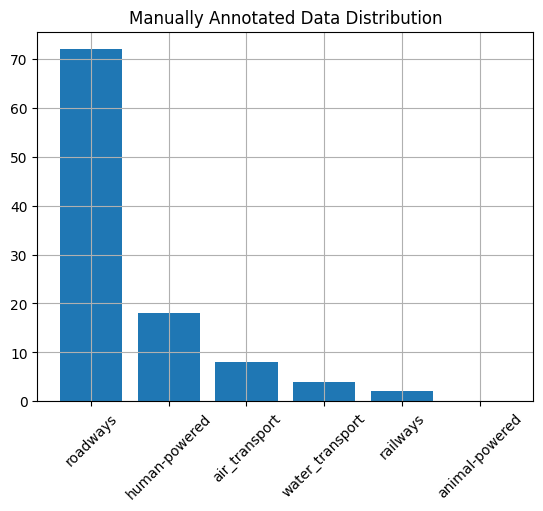

In [17]:
values = {k: v for k, v in sorted(combined_labels.items(), key=lambda item: len(item[1]), reverse=True)}

plt.title("Manually Annotated Data Distribution")
plt.bar(range(len(values)), list(map(len, values.values())), tick_label=list(values.keys()), align='center')
plt.xticks(rotation=45)
plt.grid()
plt.show()

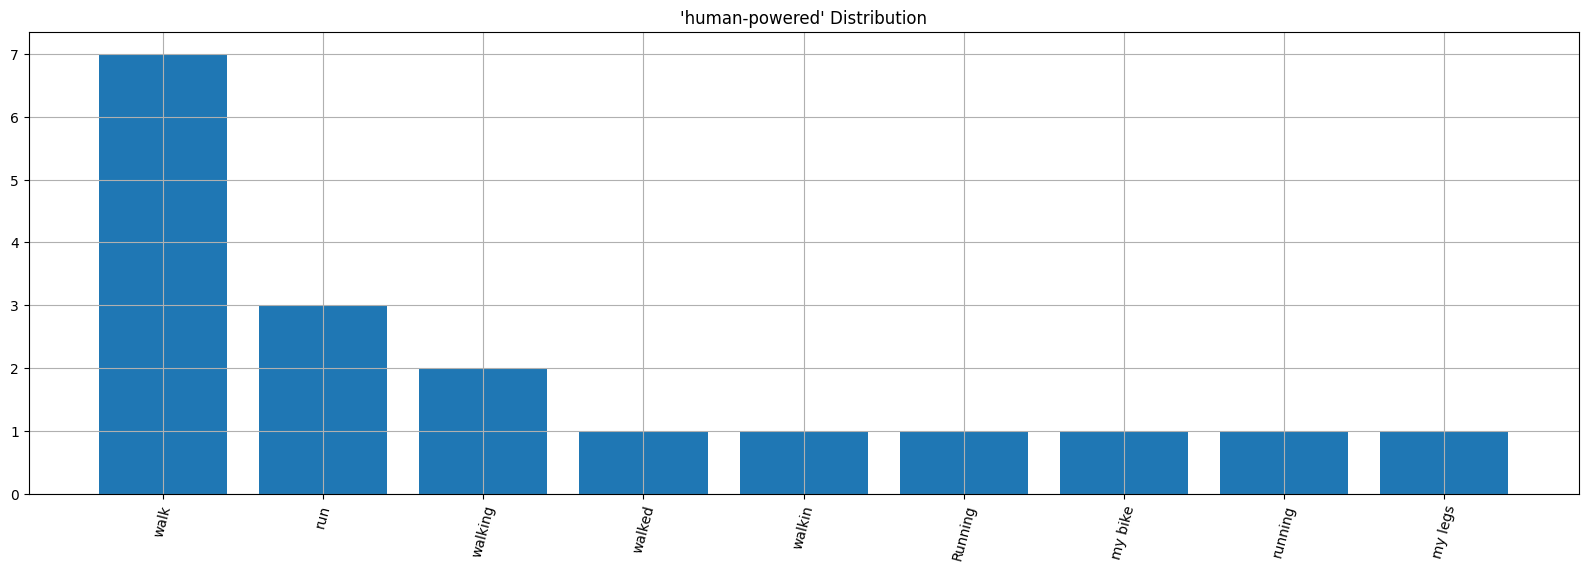

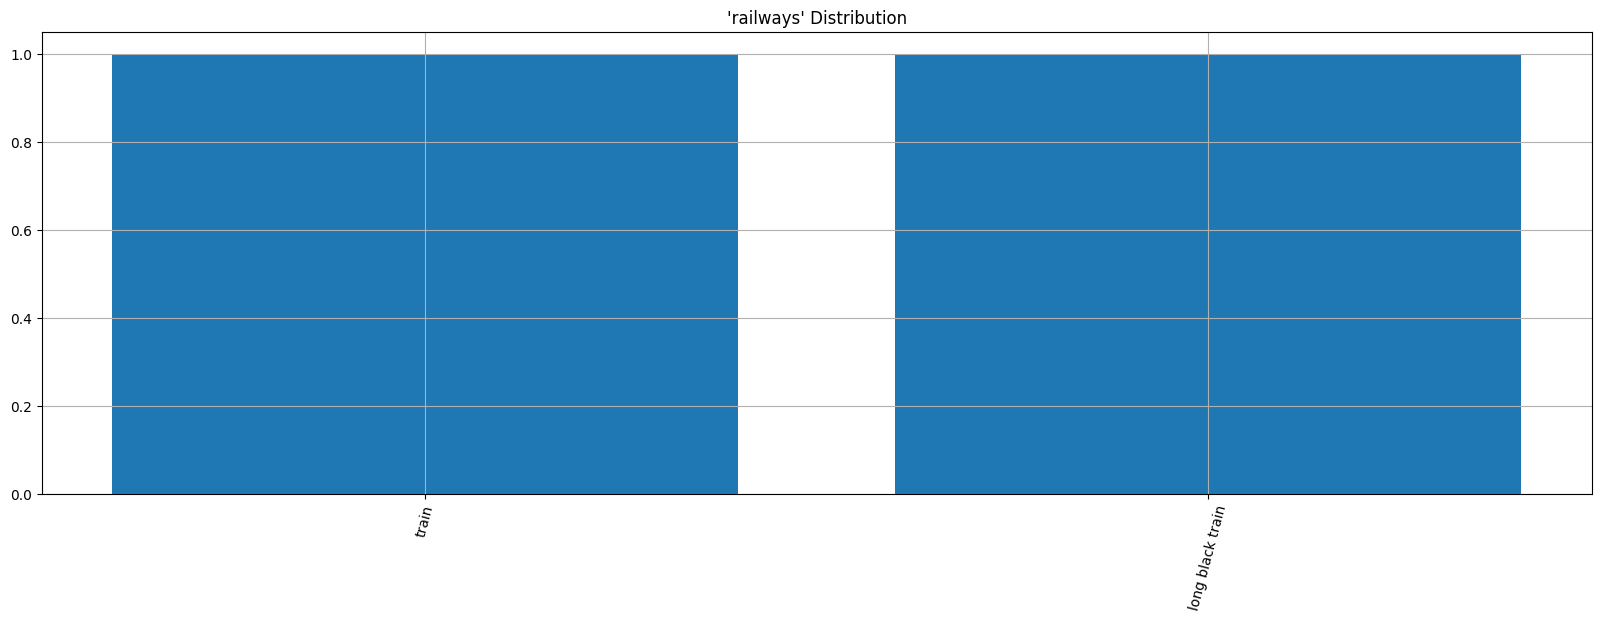

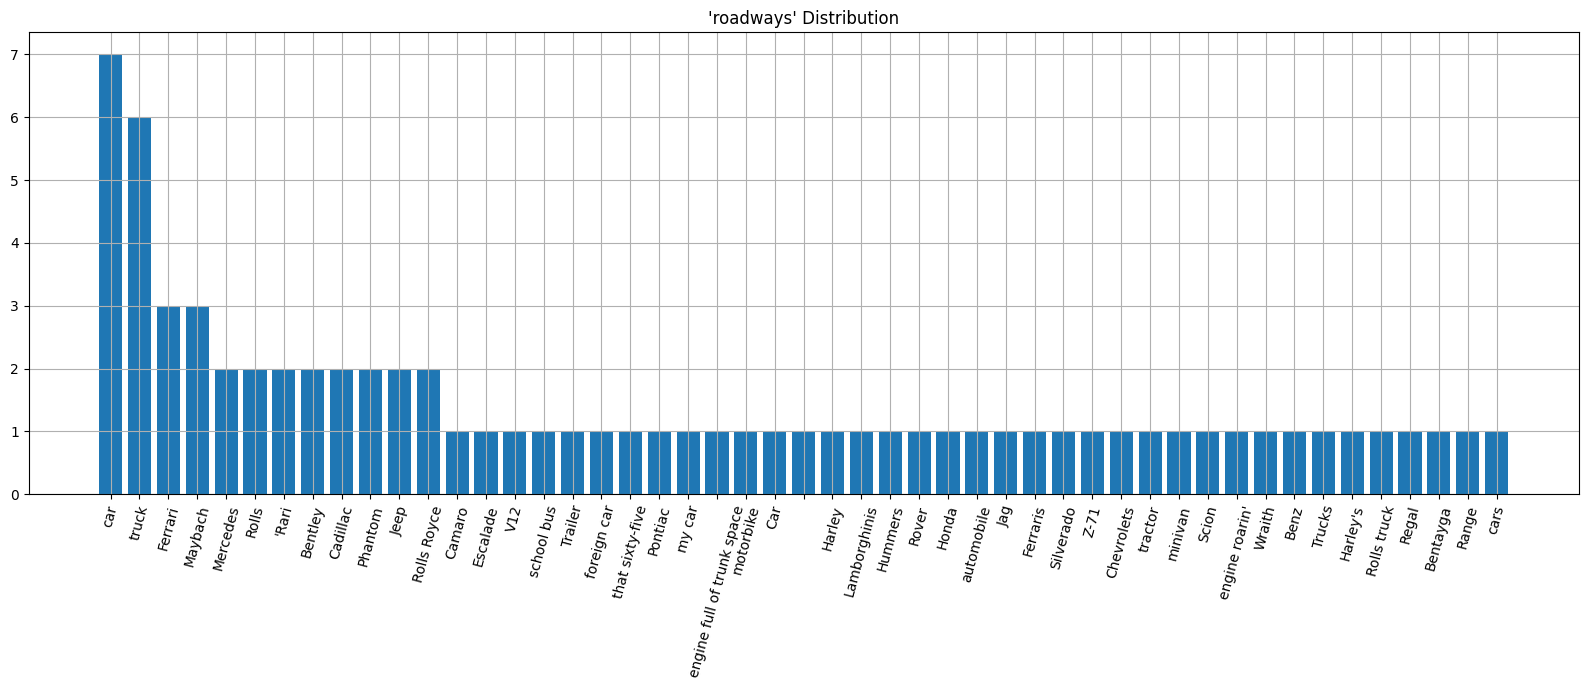

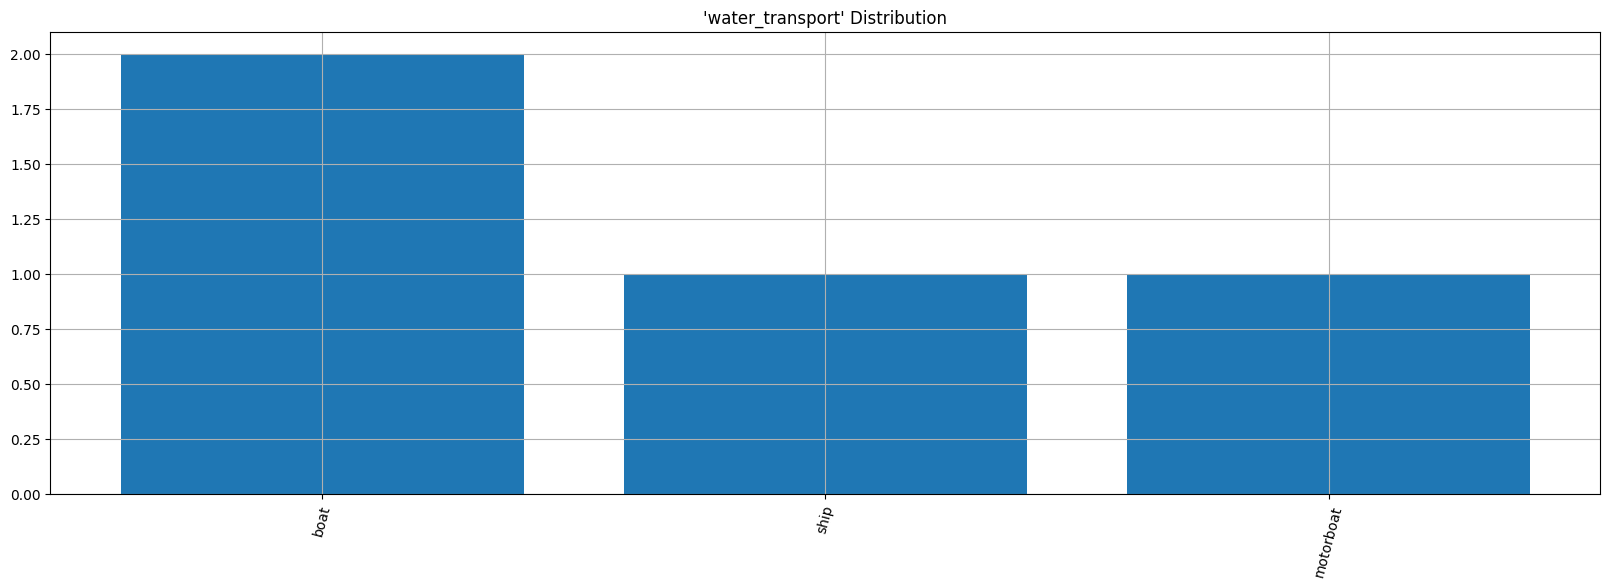

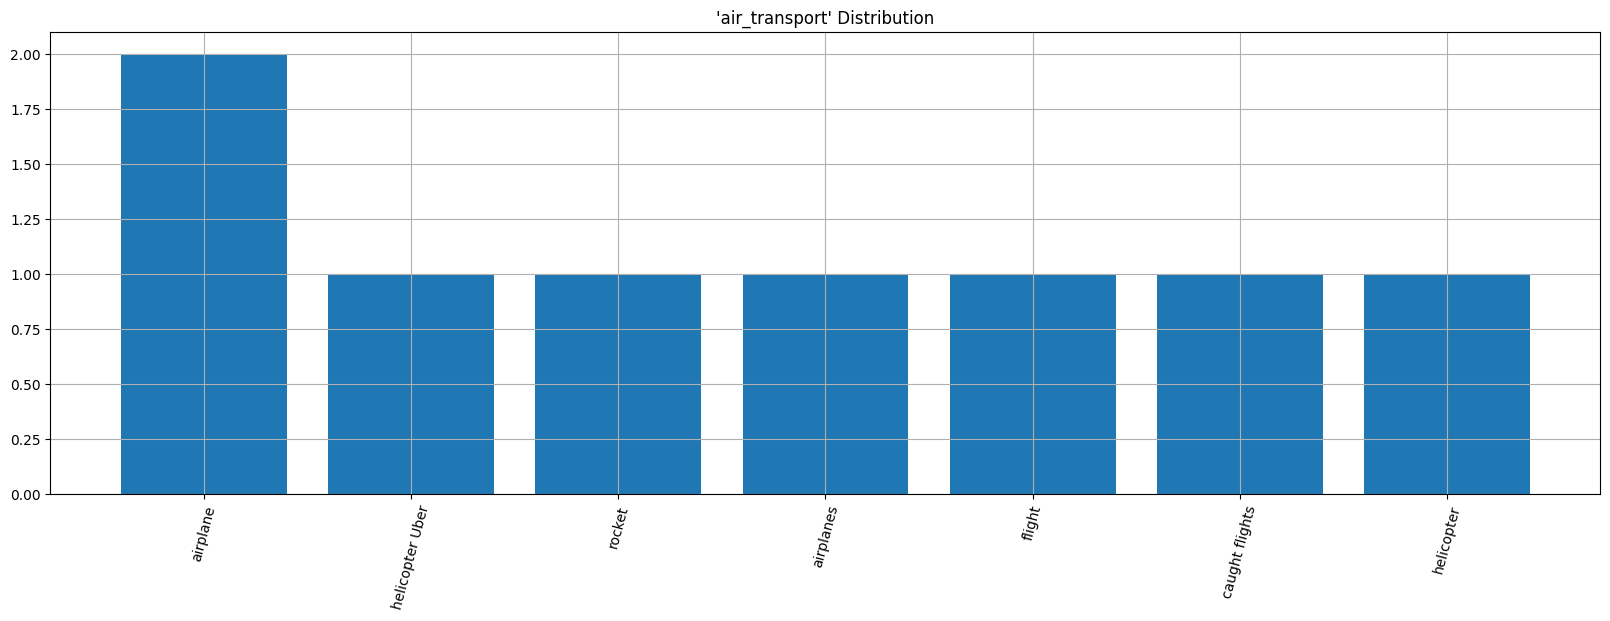

In [34]:
from collections import Counter

for i, (entity, values) in enumerate(combined_labels.items()):
    if not values: continue
    
    values = Counter(combined_labels[entity])
    values = {k: v for k, v in sorted(values.items(), key=lambda item: item[1], reverse=True)}
    
    plt.figure(figsize=(20, 6))
    plt.title(f"'{entity}' Distribution")
    plt.bar(range(len(values)), list(values.values()), tick_label=list(values.keys()), align='center')
    plt.xticks(rotation=75)
    plt.grid()
    plt.show()

# Evaluation

In [30]:
import os

labels = []
for filename in os.listdir("../data/labels_manual"):
    if not filename.endswith(".json"): continue
    
    with open(f"../data/labels_manual/{filename}") as f:
        label_ = json.load(f)
        
    label = dict()
    label["id"] = filename.split(".")[0]
    label["entities"] = label_
    
    labels.append(label)
    
with open("../data/labels_manual.jsonl", "w") as f:
    for label in labels:
        f.write(json.dumps(label) + "\n")

In [31]:
exp_name = "random_n3"
with open(f"../data/labels_automatic/{exp_name}.jsonl") as f:
    labels_automatic = [json.loads(line) for line in f]
    
labels_automatic_dict = {label["id"]: label["entities"] for label in labels_automatic} 

In [32]:
with open("../data/labels_manual.jsonl") as f:
    labels_manual = [json.loads(line) for line in f]
    
labels_manual_dict = {label["id"]: label["entities"] for label in labels_manual if label["id"] in labels_automatic_dict}    

In [66]:
from collections import Counter

def evaluate_ner_macro(true_entities_dict, predicted_entities_dict):
    """
    Evaluates NER performance over multiple examples.
    
    Each example is represented as a dictionary mapping entity types to lists of entities.
    The function aggregates counts for each entity type over all examples and then computes
    macro-averaged metrics (i.e. averages the metrics across all entity types).
    
    Args:
        true_entities_list (list of dict): Ground truth for each example.
            Example: [{"PERSON": ["Alice", "Bob"], "LOCATION": ["Paris"]}, ...]
        predicted_entities_list (list of dict): Predictions for each example.
            Example: [{"PERSON": ["Alice", "Charlie"], "LOCATION": ["Paris", "Paris"]}, ...]
    
    Returns:
        tuple: A tuple (per_entity_results, macro_results) where:
            - per_entity_results is a dict mapping each entity type to its computed
              Precision, Recall, and F1-score.
            - macro_results is a dict with Macro Precision, Macro Recall, and Macro F1-score,
              which are the averages over all entity types.
    """
    true_entities_dict = dict(sorted(true_entities_dict.items()))
    predicted_entities_dict = dict(sorted(predicted_entities_dict.items()))
    
    true_entities_list = true_entities_dict.values()
    predicted_entities_list = predicted_entities_dict.values()
    
    assert len(true_entities_list) == len(predicted_entities_list), "The number of examples must match."

    # Collect all entity types appearing in any example
    entity_types = set()
    for true_dict in true_entities_list:
        entity_types.update(true_dict.keys())
    for pred_dict in predicted_entities_list:
        entity_types.update(pred_dict.keys())

    # Dictionary to store aggregated counts per entity type
    per_entity_counts = {etype: {"TP": 0, "FP": 0, "FN": 0} for etype in entity_types}

    # Iterate over all examples and aggregate counts for each entity type
    for true_dict, pred_dict in zip(true_entities_list, predicted_entities_list):
        for etype in entity_types:
            # Get the list of entities for this type; default to empty list if missing.
            true_list = true_dict.get(etype, [])
            pred_list = pred_dict.get(etype, [])
            
            # Use Counter to account for duplicates
            true_counter = Counter(true_list)
            pred_counter = Counter(pred_list)
            
            # Count true positives: for each entity present in both, add the minimum count
            common_entities = set(true_counter.keys()) & set(pred_counter.keys())
            TP = sum(min(true_counter[ent], pred_counter[ent]) for ent in common_entities)
            
            # Count false positives: predicted count minus the matched count for every predicted entity
            FP = sum(pred_counter[ent] - min(true_counter.get(ent, 0), pred_counter[ent]) for ent in pred_counter)
            
            # Count false negatives: true count minus the matched count for every true entity
            FN = sum(true_counter[ent] - min(true_counter[ent], pred_counter.get(ent, 0)) for ent in true_counter)
            
            # Aggregate counts
            per_entity_counts[etype]["TP"] += TP
            per_entity_counts[etype]["FP"] += FP
            per_entity_counts[etype]["FN"] += FN

    # Compute precision, recall, and F1 for each entity type
    per_entity_results = {}
    for etype, counts in per_entity_counts.items():
        TP = counts["TP"]
        FP = counts["FP"]
        FN = counts["FN"]
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1        = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        per_entity_results[etype] = {"Precision": precision, "Recall": recall, "F1": f1}

    # Macro-average: average the metric scores over all entity types
    macro_precision = sum(result["Precision"] for result in per_entity_results.values()) / len(entity_types)
    macro_recall    = sum(result["Recall"] for result in per_entity_results.values()) / len(entity_types)
    macro_f1        = sum(result["F1"] for result in per_entity_results.values()) / len(entity_types)
    
    macro_results = {
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1": macro_f1
    }
    
    # Micro-average: aggregate counts over all entity types
    total_TP = sum(counts["TP"] for counts in per_entity_counts.values())
    total_FP = sum(counts["FP"] for counts in per_entity_counts.values())
    total_FN = sum(counts["FN"] for counts in per_entity_counts.values())

    micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0.0
    micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0.0
    micro_f1 = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0

    macro_results["Micro Precision"] = micro_precision
    macro_results["Micro Recall"] = micro_recall
    macro_results["Micro F1"] = micro_f1
    
    return per_entity_results, macro_results

In [46]:
for item in dict(sorted(labels_manual_dict.items())).keys():
    manual = labels_manual_dict[item]
    automatic = labels_automatic_dict[item]
    
    print(item)
    print('-' * len(item))
    print(manual)
    print(automatic)
    print()

#Beautiful_Mariah Carey
-----------------------
{'human-powered': ['bike'], 'animal-powered': [], 'railways': [], 'roadways': [], 'water_transport': [], 'air_transport': []}
{'human-powered': ['bike'], 'animal-powered': [], 'railways': [], 'roadways': [], 'water_transport': [], 'air_transport': []}

#thatPower_will
---------------
{'human-powered': [], 'animal-powered': [], 'railways': [], 'roadways': [], 'water_transport': [], 'air_transport': []}
{'human-powered': [], 'animal-powered': [], 'railways': [], 'roadways': [], 'water_transport': [], 'air_transport': []}

'Til You Can't_Cody Johnson
---------------------------
{'human-powered': [], 'animal-powered': [], 'railways': [], 'roadways': ['that sixty-five', 'Pontiac'], 'water_transport': [], 'air_transport': []}
{'human-powered': [], 'animal-powered': [], 'railways': [], 'roadways': [], 'water_transport': [], 'air_transport': []}

1-800-273-8255_Logic
--------------------
{'human-powered': [], 'animal-powered': [], 'railways': [],

In [67]:
per_entity_results, macro_results = evaluate_ner_macro(labels_manual_dict, labels_automatic_dict)

print("Per Entity Type Metrics:")
for etype, metrics in per_entity_results.items():
    print(f"  {etype}: {metrics}")

print("\nAveraged Metrics:")
for metric, value in macro_results.items():
    print(f"  {metric}: {value:.4f}")

Per Entity Type Metrics:
  human-powered: {'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0}
  air_transport: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
  animal-powered: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
  water_transport: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
  railways: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
  roadways: {'Precision': 1.0, 'Recall': 0.3333333333333333, 'F1': 0.5}

Macro-Averaged Metrics:
  Macro Precision: 0.3333
  Macro Recall: 0.2222
  Macro F1: 0.2500
  Micro Precision: 1.0000
  Micro Recall: 0.5000
  Micro F1: 0.6667


# Error Analysis

In [34]:
import json
from itertools import chain

methods = [
    "knn_n3_scn1",
    "random_n3_scn5_pt_ns"
]

fps = []
fns = []

for method in methods:
    with open(f"../data/analysis/errors/{method}_fp.json") as f:
        fp = json.load(f)
    with open(f"../data/analysis/errors/{method}_fn.json") as f:
        fn = json.load(f)
        
    if isinstance(fp, dict):
        fp = list(chain(*list(fp.values())))
    if isinstance(fn, dict):
        fn = list(chain(*list(fn.values())))
        
    fps.append(fp)
    fns.append(fn)

In [ ]:
with open("../data/entity_metadata.json") as f:
    entity_metadata = json.load(f)
    
def get_entity_vocab(entity_metadata):
    entity_vocab = {}
    for entity in entity_metadata:
        entity_vocab[entity] = entity_metadata[entity]["items"]
    
    return entity_vocab

entity_vocab = get_entity_vocab(entity_metadata)

In [46]:
from collections import defaultdict, Counter

fp_dicts = []

for fp in fps:
    fp_dict = defaultdict(list)

    for item in fp:
        fp_dict[item['entity']].extend(
            list(set(list(map(str.lower, item['pred']))) - set(list(map(str.lower, item['true']))))
        )

    fp_dicts.append(fp_dict)

In [62]:
fn_dicts = []

for fn in fns:
    fn_dict = defaultdict(list)

    for item in fn:
        fn_dict[item['entity']].extend(
            list(set(list(map(str.lower, item['true']))) - set(list(map(str.lower, item['pred']))))
        )

    fn_dicts.append(fn_dict)

In [48]:
fp_dicts[0].keys(), fp_dicts[1].keys()

(dict_keys(['air_transport', 'roadways', 'water_transport']),
 dict_keys(['roadways', 'railways', 'air_transport', 'animal-powered', 'human-powered', 'water_transport']))

In [49]:
for fp_dict in fp_dicts:
    for entity_type in fp_dict.keys():
        print(f"{entity_type}:", set(fp_dict[entity_type]) & set(entity_vocab[entity_type]))
        
    print('-'*50)

air_transport: {'helicopter', 'glider'}
roadways: {'motorcycle'}
water_transport: set()
--------------------------------------------------
roadways: {'motorcycle'}
railways: set()
air_transport: {'helicopter', 'airplane'}
animal-powered: set()
human-powered: set()
water_transport: set()
--------------------------------------------------


In [50]:
fn_dicts[0].keys(), fn_dicts[1].keys()

(dict_keys(['roadways', 'human-powered', 'air_transport', 'water_transport']),
 dict_keys(['roadways', 'air_transport', 'human-powered', 'water_transport', 'railways']))

In [63]:
for fn_dict in fn_dicts:
    for entity_type in fn_dict.keys():
        print(f"{entity_type}:", set(fn_dict[entity_type]) & set(entity_vocab[entity_type]))
        
    print('-'*50)

roadways: {'truck'}
human-powered: set()
air_transport: {'airplane'}
water_transport: set()
--------------------------------------------------
roadways: {'truck'}
air_transport: set()
human-powered: set()
water_transport: set()
railways: set()
--------------------------------------------------


In [59]:
fp_dicts[0]

defaultdict(list,
            {'air_transport': ['glider',
              'tailspun airplane',
              'helicopter',
              'flight',
              'private plane',
              'flights',
              'private jet'],
             'roadways': ['the road',
              'john deere',
              'dead-end highway',
              'two-lane road',
              'fast cars',
              'trailer park truck stop',
              'doublewide quick stop',
              'motorcycles',
              'motorcycle',
              'motorcycle',
              'vehicle',
              'new coupe',
              'back seat of my car',
              'ghost',
              'harley',
              'bitch',
              'cadillac',
              'red taillights',
              'lyft',
              'tessie',
              'g',
              'tesla',
              'road',
              'highway',
              'back road',
              'downtown streets'],
             'water_transport':

In [58]:
fp_dicts[1]

defaultdict(list,
            {'roadways': ['road',
              'roads',
              'highway',
              'road rage',
              'fast cars',
              'road',
              'truck stop',
              'motorcycles',
              'cadillac',
              'road',
              'motorcycle',
              'back road'],
             'railways': ['train'],
             'air_transport': ['airplane',
              'helicopter',
              'private plane',
              'flights'],
             'animal-powered': ['animal'],
             'human-powered': ['pedal bike'],
             'water_transport': ['40 hp johnson']})

In [68]:
fns[1]

[{'entity': 'roadways', 'true': ['that sixty-five', 'Pontiac'], 'pred': []},
 {'entity': 'roadways', 'true': ['Ferrari', 'Honda'], 'pred': []},
 {'entity': 'air_transport', 'true': ['rocket'], 'pred': []},
 {'entity': 'human-powered', 'true': ['walk'], 'pred': []},
 {'entity': 'roadways', 'true': ['truck', ''], 'pred': ['truck', 'roads']},
 {'entity': 'roadways', 'true': ['minivan', 'Scion'], 'pred': []},
 {'entity': 'human-powered', 'true': ['walk'], 'pred': []},
 {'entity': 'human-powered', 'true': ['walk'], 'pred': []},
 {'entity': 'water_transport', 'true': ['ship'], 'pred': []},
 {'entity': 'human-powered', 'true': ['walkin'], 'pred': []},
 {'entity': 'human-powered', 'true': ['walk'], 'pred': []},
 {'entity': 'human-powered', 'true': ['walk'], 'pred': []},
 {'entity': 'human-powered', 'true': ['running'], 'pred': []},
 {'entity': 'railways', 'true': ['long black train'], 'pred': ['train']},
 {'entity': 'roadways',
  'true': ['Silverado', 'Z-71', 'Chevrolets'],
  'pred': ['Silvera

In [65]:
fn_dicts[1]

defaultdict(list,
            {'roadways': ['pontiac',
              'that sixty-five',
              'ferrari',
              'honda',
              '',
              'scion',
              'minivan',
              'z-71',
              'chevrolets',
              'rolls royce',
              'car',
              'cars',
              'v12',
              'truck',
              'trailer',
              'jag',
              'mercedes',
              'rolls',
              'engine full of trunk space',
              'car',
              'motorbike',
              'car',
              'maybach',
              'rolls royce',
              'bentayga',
              "'rari",
              'car',
              "harley's",
              'ferrari',
              'truck',
              'rolls truck',
              'trucks',
              'phantom',
              'ferraris',
              'car',
              'maybach',
              'range',
              'maybach',
              'phantom',
   